![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+Matching+Engine+For+Document+Q%26A.ipynb)

# Vertex AI Matching Engine For Document Q&A

[Vertex AI Matching Engine]() provides a stateful, low-latency, vector database.  This provides vector similarity-matching as a service.  

The document Q&A notebooks in this series each save embeddings files to GCS that can be used as input for creating an index in Vertex AI Matching Engine.

**Prerequisites:**
- One of the document Q&A notebooks in [this series](./readme.md)

**Resources:**
- [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)- Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Setup

Inputs

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
EXPERIMENT = 'faa_regulations' # list the EXPERIMENT from the choosen prerequisite notebook
SERIES = 'applied-genai'

# retrieve results from: GCS, BQ - saved by the choosen prerequisite notebook
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# first question to ask
question = "Does the length or altitude of a flight impact what devices I can carry onboard?"

Packages

In [9]:
import io
import json
import base64
import time

import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import bigquery

Clients

In [10]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Load And Review Data

In [11]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/embeddings.json')
embeddings = [json.loads(line) for line in blob.download_as_text().splitlines()]

In [12]:
embeddings[0].keys()

dict_keys(['id', 'embedding'])

In [13]:
len(embeddings)

901

In [14]:
len(embeddings[0]['embedding'])

768

In [15]:
embeddings[0]['embedding'][0:5]

[-0.030369535088539124,
 0.022805988788604736,
 0.0025168771389871836,
 -0.0131516819819808,
 0.033633410930633545]

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextGenerationModel)

In [16]:
# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [17]:
embedding_model.get_embeddings([question])[0].values[0:5]

[-0.01794271171092987,
 0.009826515801250935,
 0.031292855739593506,
 0.045290589332580566,
 0.02171672135591507]

Test test generation (llm) model:

In [18]:
textgen_model.predict(question)

The length or altitude of a flight does not impact what devices you can carry onboard. However, some devices may be prohibited or restricted depending on the airline's policies. For example, some airlines may prohibit the use of electronic devices during takeoff and landing, while others may allow them but require them to be stowed away during those times. Additionally, some airlines may have restrictions on the size or weight of electronic devices that can be carried onboard.

---
## Configure & Create The Index

There are several ways to configure and index for Vertex AI Matching Engine.  The choice made will depend on the size of the index in most cases.  In this case the number of embedding is rather small as it represents the elements of single document.  The brute force, or standard linear search, is implemented.

Also, to enable filtering when doing vector searches you can include [namespaces and tokens](https://cloud.google.com/vertex-ai/docs/matching-engine/filtering#specify-namespaces-tokens) when creating the input data.

**Resources**
- [Managed Indexes](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index)
    - [Configure Indexes](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index)
        - [aiplatform API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.MatchingEngineIndex#google_cloud_aiplatform_MatchingEngineIndex_create_brute_force_index)
        - [aiplatform V1 API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.index_service.IndexServiceClient#google_cloud_aiplatform_v1_services_index_service_IndexServiceClient_create_index)
        - [aiplatform V1beta1 API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1beta1.services.index_service)

In [19]:
list_indexes = aiplatform.MatchingEngineIndex.list(filter = f'display_name={EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')
if list_indexes:
    print('Found Index from previous run')
    index = list_indexes[0]
else:
    print('Creating new index after first checking that none existed from previous run.')
    index = aiplatform.MatchingEngineIndex.create_brute_force_index(
        display_name = EXPERIMENT,
        contents_delta_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/vertex_matching',
        dimensions = len(embeddings[0]['embedding']),
        distance_measure_type = "DOT_PRODUCT_DISTANCE",
        description = EXPERIMENT,
        labels = dict(series = SERIES, experiment = EXPERIMENT),
        sync = False
    )

Creating new index after first checking that none existed from previous run.
Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/1026793852137/locations/us-central1/indexes/5168892123105198080/operations/120097662237147136


In [20]:
index.wait()

MatchingEngineIndex created. Resource name: projects/1026793852137/locations/us-central1/indexes/5168892123105198080
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/1026793852137/locations/us-central1/indexes/5168892123105198080')


In [21]:
index.name

'5168892123105198080'

In [22]:
index.resource_name

'projects/1026793852137/locations/us-central1/indexes/5168892123105198080'

In [23]:
print(f'View the Matching Engine Indexes In the Console:\nhttps://console.cloud.google.com/vertex-ai/matching-engine/indexes?project={PROJECT_ID}')

View the Matching Engine Indexes In the Console:
https://console.cloud.google.com/vertex-ai/matching-engine/indexes?project=statmike-mlops-349915


---
## Networking Considerations

In the example here, a public endpoint is used for demonstration as it requires no further setup.  For lower latency it is best to use a VPC with direct VPC Peering.
- [Overview of Matching Engine networking](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/match-eng-setup)
- [More on VPC Network Peering for Vertex AI](https://cloud.google.com/vertex-ai/docs/general/vpc-peering)



---
## Create The Index Endpoint

Create an index endpoint that the index will be deployed to.

**Resources**
- [Index Endpoints](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public#create-index-endpoint)
    - [aiplatform API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.MatchingEngineIndexEndpoint#google_cloud_aiplatform_MatchingEngineIndexEndpoint_create)
    - [aiplatform V1 API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.index_endpoint_service.IndexEndpointServiceClient#google_cloud_aiplatform_v1_services_index_endpoint_service_IndexEndpointServiceClient_create_index_endpoint)
    - [aiplatform V1beta1 API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1beta1.services.index_endpoint_service.IndexEndpointServiceClient#google_cloud_aiplatform_v1beta1_services_index_endpoint_service_IndexEndpointServiceClient_create_index_endpoint)
    
    
**Networking Considerations**

>In the example here, a public endpoint is used for demonstration as it requires no further setup.  For lower latency it is best to use a VPC with direct VPC Peering.
>- [Overview of Matching Engine networking](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/match-eng-setup)
>- [More on VPC Network Peering for Vertex AI](https://cloud.google.com/vertex-ai/docs/general/vpc-peering)

In [81]:
list_endpoints = aiplatform.MatchingEngineIndexEndpoint.list(filter = f'display_name={SERIES} AND labels.series={SERIES}')
if list_endpoints:
    print('Found Endpoint from previous run')
    endpoint = list_endpoints[0]

Found Endpoint from previous run


In [82]:
list_endpoints = aiplatform.MatchingEngineIndexEndpoint.list(filter = f'display_name={SERIES} AND labels.series={SERIES}')
if list_endpoints:
    print('Found Endpoint from previous run')
    endpoint = list_endpoints[0]
else:
    print('Creating new endpoint after first checking that none existed from previous run.')
    endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
        display_name = SERIES,
        description = SERIES,
        public_endpoint_enabled = True,
        labels = dict(series = SERIES),
        sync = False
    )

Found Endpoint from previous run


In [83]:
endpoint.wait()

In [84]:
endpoint.name

'6340953926128369664'

In [85]:
endpoint.resource_name

'projects/1026793852137/locations/us-central1/indexEndpoints/6340953926128369664'

In [86]:
print(f'View the Matching Engine Index Endpoints In the Console:\nhttps://console.cloud.google.com/vertex-ai/matching-engine/index-endpoints?project={PROJECT_ID}')

View the Matching Engine Index Endpoints In the Console:
https://console.cloud.google.com/vertex-ai/matching-engine/index-endpoints?project=statmike-mlops-349915


---
## Deploy The Index To The Index Endpoint

Deploy the index to the endpoint.  In this example the default resources are used but these can be configured, including [enabling autoscaling](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public#autoscaling). More on [default machine types](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index).

**Resources**
- [Index Endpoints](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public#deploy-index)
    - [aiplatform API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.MatchingEngineIndexEndpoint#google_cloud_aiplatform_MatchingEngineIndexEndpoint_deploy_index)
    - [aiplatform V1 API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.index_endpoint_service.IndexEndpointServiceClient#google_cloud_aiplatform_v1_services_index_endpoint_service_IndexEndpointServiceClient_deploy_index)
    - [aiplatform V1beta1 API](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1beta1.services.index_endpoint_service.IndexEndpointServiceClient#google_cloud_aiplatform_v1beta1_services_index_endpoint_service_IndexEndpointServiceClient_deploy_index)

In [100]:
deployed_indexes = endpoint.deployed_indexes
if EXPERIMENT.replace('-', '_') in [d.id for d in deployed_indexes]:
    print(f"The Index {EXPERIMENT.replace('-', '_')} is deployed on this endpoint.")
else:
    print(f"Starting operation to deploy the Index {EXPERIMENT.replace('-', '_')} on the endpoint.")
    client = aiplatform.gapic.IndexEndpointServiceClient(client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"})
    operation = client.deploy_index(
        index_endpoint = endpoint.resource_name,
        deployed_index = dict(
            id = EXPERIMENT.replace('-', '_'),
            index = index.resource_name,
            display_name = EXPERIMENT
        ),
        timeout = None
    )

Starting operation to deploy the Index faa_regulations on the endpoint.


In [101]:
while True:
    if operation.done():
        print('The index is deployed.')
        break
    print('Waiting on deployment of index to complete...')
    time.sleep(60)

Waiting on deployment of index to complete...
Waiting on deployment of index to complete...
Waiting on deployment of index to complete...
Waiting on deployment of index to complete...
Waiting on deployment of index to complete...
The index is deployed.


In [102]:
endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name = endpoint.resource_name
)

In [103]:
print(f'View the deployed indexes for the the Index Endpoint in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/index-endpoints/{endpoint.name}?project={PROJECT_ID}')

View the deployed indexes for the the Index Endpoint in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/index-endpoints/6340953926128369664?project=statmike-mlops-349915


In [104]:
endpoint.deployed_indexes

[id: "faa_regulations"
index: "projects/1026793852137/locations/us-central1/indexes/5168892123105198080"
display_name: "faa_regulations"
create_time {
  seconds: 1684193267
  nanos: 977209000
}
index_sync_time {
  seconds: 1684193543
  nanos: 74011000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
, id: "mlb_rules"
index: "projects/1026793852137/locations/us-central1/indexes/2994779402992091136"
display_name: "mlb-rules"
create_time {
  seconds: 1684181012
  nanos: 955271000
}
index_sync_time {
  seconds: 1684193339
  nanos: 262132000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

---
## Online Query

**Resources**
- [Query Endpoint](https://cloud.google.com/vertex-ai/docs/matching-engine/query-index-public-endpoint)

### Retrieve an embedding based on id:

[aiplatform.MatchingEngineIndexEndpoint.read_index_datapoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.MatchingEngineIndexEndpoint#google_cloud_aiplatform_MatchingEngineIndexEndpoint_read_index_datapoints)

In [105]:
endpoint.read_index_datapoints(
    deployed_index_id = EXPERIMENT.replace('-', '_'),
    ids = ['0']
)[0].feature_vector[0:5]

[-0.030369535088539124,
 0.022805988788604736,
 0.0025168771389871836,
 -0.0131516819819808,
 0.033633410930633545]

### Get ids for neighbors of questions embedding:

[aiplatform.MatchingEngineIndexEndpoint.find_neighbors()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.MatchingEngineIndexEndpoint#google_cloud_aiplatform_MatchingEngineIndexEndpoint_find_neighbors)

If the input data included [namespaces and tokens](https://cloud.google.com/vertex-ai/docs/matching-engine/filtering#specify-namespaces-tokens) then those can be used to restrict vector searches to a subset by using the `filter` parameter - [details](https://cloud.google.com/vertex-ai/docs/matching-engine/filtering).

In [106]:
matches = endpoint.find_neighbors(
    deployed_index_id = EXPERIMENT.replace('-', '_'),
    queries = [embedding_model.get_embeddings([question])[0].values],
    num_neighbors = 4
)

In [107]:
matches

[[MatchNeighbor(id='814', distance=0.7294114828109741),
  MatchNeighbor(id='378', distance=0.7198103070259094),
  MatchNeighbor(id='802', distance=0.7186585664749146),
  MatchNeighbor(id='821', distance=0.7070361971855164)]]

In [108]:
matches = [(int(match.id), match.distance) for match in matches[0]]

In [109]:
matches

[(814, 0.7294114828109741),
 (378, 0.7198103070259094),
 (802, 0.7186585664749146),
 (821, 0.7070361971855164)]

---
## DocumentBot Setup With Matching Engine

To use DocumentBOt with Vertex AI Matching Engine we need to retrieve the documents (as before) and configure the DocumentBot to use the endpoint for the matching engine index:

In [110]:
if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load results: the raw data from docai parsing
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    results = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load documents: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    documents = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as string, use .encode() to convert to bytes, use base64.decodebytes to decode
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        page_images.append(document_image)    
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents'):
    print('Copying previous run from BigQuery')
    
    # load results: the raw data from docai parsing
    results = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_results` ORDER BY metadata.row').to_dataframe().to_dict('records')
    
    # load documents: the perpared results from the docai parsing results
    documents = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_documents` ORDER BY metadata.row').to_dataframe().to_dict('records')
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as base64 encoded bytes in BQ and retrieved in that format
                result['pages'][0]['image']['content']
            )
        )
        page_images.append(document_image) 
else:
    print('No previous run available to copy over')

Copying previous run from GCS


In [111]:
def search_index(query, k):
    matches = endpoint.find_neighbors(
                deployed_index_id = EXPERIMENT.replace('-', '_'),
                queries = [embedding_model.get_embeddings([query])[0].values],
                num_neighbors = k
            )
    return [(int(match.id), match.distance) for match in matches[0]]

In [112]:
search_index(question, 4)

[(814, 0.7294114828109741),
 (378, 0.7198103070259094),
 (802, 0.7186585664749146),
 (821, 0.7070361971855164)]

In [113]:
def document_bot(question):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    
    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    # prepare context for prompt
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])
    
    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.

        {context}

        Question:
        {question}

        Answer and Explanation:
    """

    #print(prompt)

    # retrieve response
    response = textgen_model.predict(prompt)
    
    # get closest document to the response:
    likely_source = search_index(response, k=1)[0]
    
    # declare likely source: if closest document to response was in context pick it, otherwise pick first context match
    if likely_source[0] in [rd[0] for rd in relevant_documentation]:
        likely = True
        likely_document = documents[likely_source[0]]
    else:
        likely = False
        likely_document = documents[relevant_documentation[0][0]]


    sources = "\n".join(f"* {documents[doc[0]]['metadata']['source_document']}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)
    answer = f"""## Response
### Question
{question}
### Answer
{response}
### Why?
{likely_document['page_content']}
* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[1]:.2f}
* {likely_document['metadata']['source_document']}#page={likely_document['metadata']['page']}
### Sources
{sources}        
    """
    IPython.display.display(IPython.display.Markdown(answer))
        
    #font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
    document_image = page_images[likely_document['metadata']['page']-1]
    vertices = documents[likely_document['metadata']['row']]['extras']['vertices']
    draw = PIL.ImageDraw.Draw(document_image).polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
    ], outline = 'green', width = 5)
    IPython.display.display(document_image.resize((800, 1000)))

    return

In [114]:
question

'Does the length or altitude of a flight impact what devices I can carry onboard?'

## Response
### Question
Does the length or altitude of a flight impact what devices I can carry onboard?
### Answer
Yes, the length and altitude of a flight can impact what devices you can carry onboard. For example, if you are flying at an altitude of more than 10,000 feet MSL or 2,000 feet AGL, whichever is higher, you will not be allowed to carry any electronic devices that emit radio waves, such as cell phones, laptops, or tablets. This is because these devices can interfere with the aircraft's navigation and communication systems.
### Why?
(4) While carrying more than one pas-
senger.
(5) At night.
(6) In Class A airspace.
(7) In Class B, C, and D airspace, at
an airport located in Class B, C, or D
airspace, and to, from, through, or at
an airport having an operational con-
trol tower unless you have met the re-
quirements specified in § 61.325.
(8) Outside the United States, unless
you have prior authorization from the
country in which you seek to operate.
Your sport pilot certificate carries the
limit "Holder does not meet ICAO re-
quirements.'
6
* page: 120, relevance to answer: 0.73
* https://www.govinfo.gov/content/pkg/CFR-2022-title14-vol2/pdf/CFR-2022-title14-vol2-part61.pdf#page=120
### Sources
* https://www.govinfo.gov/content/pkg/CFR-2022-title14-vol2/pdf/CFR-2022-title14-vol2-part61.pdf#page=120
	* Document: CFR-2022-title14-vol2-part61.pdf, page: 120, relevance to question: 0.73
* https://www.govinfo.gov/content/pkg/CFR-2022-title14-vol2/pdf/CFR-2022-title14-vol2-part61.pdf#page=56
	* Document: CFR-2022-title14-vol2-part61.pdf, page: 56, relevance to question: 0.72
* https://www.govinfo.gov/content/pkg/CFR-2022-title14-vol2/pdf/CFR-2022-title14-vol2-part61.pdf#page=118
	* Document: CFR-2022-title14-vol2-part61.pdf, page: 118, relevance to question: 0.72
* https://www.govinfo.gov/content/pkg/CFR-2022-title14-vol2/pdf/CFR-2022-title14-vol2-part61.pdf#page=121
	* Document: CFR-2022-title14-vol2-part61.pdf, page: 121, relevance to question: 0.71
* https://www.govinfo.gov/content/pkg/CFR-2022-title14-vol2/pdf/CFR-2022-title14-vol2-part61.pdf#page=15
	* Document: CFR-2022-title14-vol2-part61.pdf, page: 15, relevance to question: 0.70        
    

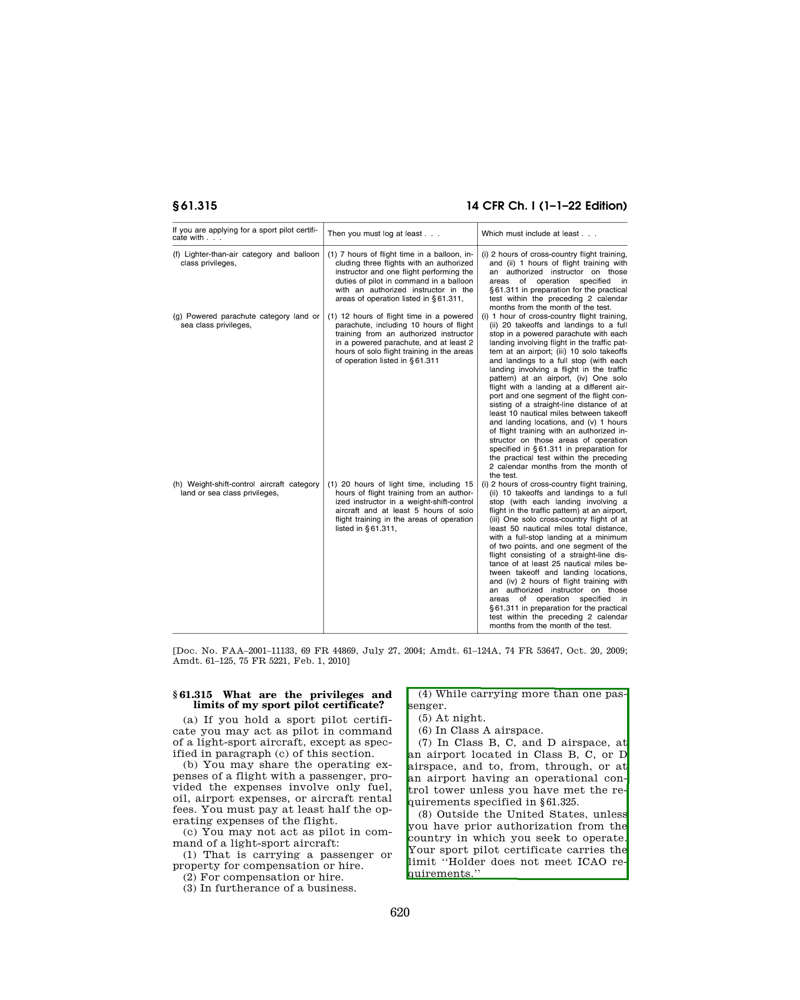

In [115]:
document_bot(question)

---
## Remove Resources

In [64]:
remove_all = False

In [65]:
if remove_all:
    #endpoint.undeploy_all()
    endpoint.delete(force = True) # force = True also delete deployed indexes first
    index.delete()